<a href="https://colab.research.google.com/github/HolyBayes/HSE_Intro2DL2021/blob/master/hometasks/assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Подготовка данных (1 балл)

Данные представляют собой набор первых 10 букв от A до J латинского алфавита (каждая буква - класс), написанных разными шрифтами. Ваша задача - написать классификатор для этих данных, определяющий буквы на изображении

In [1]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz
!tar -xvf notMNIST_large.tar.gz >> /dev/null

--2021-01-28 10:40:28--  http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247336696 (236M) [application/x-gzip]
Saving to: ‘notMNIST_large.tar.gz’

notMNIST_large.tar. 100%[===================>] 235.88M  24.5MB/s    in 10s     

2021-01-28 10:40:39 (22.5 MB/s) - ‘notMNIST_large.tar.gz’ saved [247336696/247336696]



In [2]:
DATA_DIR = 'notMNIST_large/'

In [3]:
from glob import glob
from PIL import Image
import os

for img_path in glob(f'{DATA_DIR}/**/*.png'):
  try:
    img = Image.open(img_path)
  except:
    # удалите файлы, которые не читаются
    os.remove(img_path)

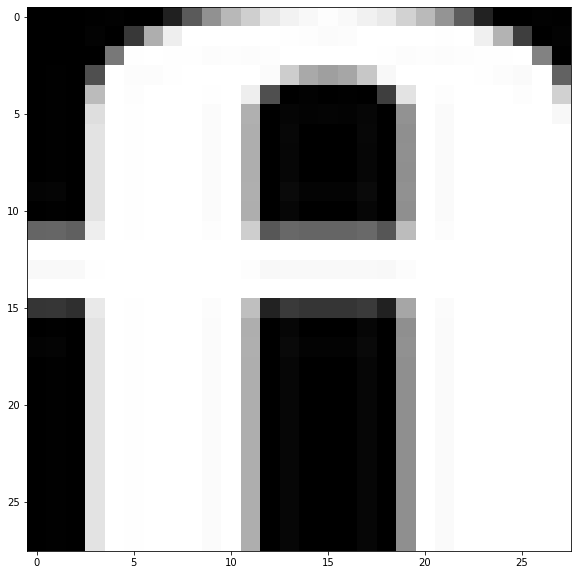

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(17,10))
letter = 'A'
img = cv2.imread(os.path.join(DATA_DIR, letter, os.listdir(f'{DATA_DIR}/{letter}/')[0]))
plt.imshow(img)

# Модель (3 балла)

In [5]:
# зафиксируем всевозможные сиды

seed = 42

import os
os.environ['PYTHONHASHSEED']=str(seed)

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

import tensorflow as tf
tf.compat.v1.set_random_seed(seed)



In [6]:
import os
import keras
from keras.models import Sequential
from keras.preprocessing import image
from keras.layers.core import Activation, Reshape, Dense, Flatten
from keras.layers import Conv2D, MaxPool2D, InputLayer, BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalMaxPool2D
from keras.models import Model

n_classes = len(os.listdir(DATA_DIR))


# YOUR CODE HERE

In [7]:
IMG_SIZE = img.shape

In [8]:
IMG_SIZE

(28, 28, 3)

In [9]:
from keras.layers.advanced_activations import LeakyReLU

def create_model():

  model = Sequential()

  # сделаем два conv-conv-pool блока

  model.add(Conv2D(16, (3, 3), padding='same', input_shape=IMG_SIZE))
  model.add(LeakyReLU(0.1))
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(LeakyReLU(0.1))
  model.add(MaxPool2D())

  model.add(Conv2D(32, (3, 3), padding='same', input_shape=IMG_SIZE))
  model.add(LeakyReLU(0.1))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(LeakyReLU(0.1))
  model.add(MaxPool2D())

  # два полносвязных слоя с софтмаксом

  model.add(Flatten())
  model.add(Dense(256))
  model.add(LeakyReLU(0.1))
  model.add(Dense(n_classes))
  model.add(Activation('softmax'))

  return model

# Аугментация данных (3 балла)

train/val split должен быть 9/1 !

In [10]:
# Подсказка: train/val split удобно делать вот так https://stackoverflow.com/questions/53037510/can-flow-from-directory-get-train-and-validation-data-from-the-same-directory-in (самый залайканый ответ)

""" Data generators initialization: for train and validation sets """

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.1, shear_range=0.15, rotation_range=15, validation_split=0.1,)
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size = (IMG_SIZE[0], IMG_SIZE[1]),
    class_mode='categorical',
    batch_size=32,
    subset='training',
    seed=seed
)

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)  # same split due to fixed seed
#  no augmentation for val data

valid_generator = valid_datagen.flow_from_directory(
    DATA_DIR,
    target_size = (IMG_SIZE[0], IMG_SIZE[1]),
    class_mode='categorical',
    batch_size=32,
    subset='validation',
    seed=seed
)

Found 476205 images belonging to 10 classes.
Found 52909 images belonging to 10 classes.


In [11]:
from keras import backend as K

def reset_tf_session():
    curr_session = tf.compat.v1.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.compat.v1.InteractiveSession(config=config)
    tf.compat.v1.keras.backend.set_session(s)
    return s

In [12]:
s = reset_tf_session()

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0

# Обучение модели

val_accuracy > 0.85 - 1 балл

val_accuracy > 0.88 - 2 балла

val_accuracy > 0.91 - 3 балла

val_accuracy > 0.92 - 4 балла


**Максимальный суммарный балл** - 11

**Финальная оценка**: min(суммарный балл, 10)


In [13]:
step_size_train = (train_generator.n // train_generator.batch_size)
step_size_valid = (valid_generator.n // valid_generator.batch_size)

model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(learning_rate=5e-3),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

INIT_LR  = 5e-3
# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch



In [14]:
from keras import backend as K

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

In [15]:
EPOCHS = 10

model.fit(
    x=train_generator,
    validation_data=valid_generator,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
    ],
    verbose=1,
    epochs=EPOCHS,
    steps_per_epoch=step_size_train,
    validation_steps=step_size_valid,
)

Epoch 1/10
Learning rate: 0.005
14881/14881 [==============================] - 321s 21ms/step - loss: 0.4128 - accuracy: 0.8770 - val_loss: 0.2195 - val_accuracy: 0.9347
Epoch 2/10
Learning rate: 0.0045
14881/14881 [==============================] - 309s 21ms/step - loss: 0.2652 - accuracy: 0.9194 - val_loss: 0.2030 - val_accuracy: 0.9386
Epoch 3/10
Learning rate: 0.00405
14881/14881 [==============================] - 308s 21ms/step - loss: 0.2417 - accuracy: 0.9259 - val_loss: 0.2001 - val_accuracy: 0.9392
Epoch 4/10
Learning rate: 0.003645
14881/14881 [==============================] - 308s 21ms/step - loss: 0.2247 - accuracy: 0.9306 - val_loss: 0.1882 - val_accuracy: 0.9436
Epoch 5/10
Learning rate: 0.0032805
14881/14881 [==============================] - 308s 21ms/step - loss: 0.2108 - accuracy: 0.9353 - val_loss: 0.2003 - val_accuracy: 0.9416
Epoch 6/10
Learning rate: 0.00295245
14881/14881 [==============================] - 307s 21ms/step - loss: 0.2016 - accuracy: 0.9371 - val_l

In [16]:
res = model.evaluate(valid_generator, return_dict=True)

1654/1654 [==============================] - 12s 7ms/step - loss: 0.1881 - accuracy: 0.9473


In [17]:
res

{'accuracy': 0.9473057389259338, 'loss': 0.18808430433273315}